<a href="https://colab.research.google.com/github/GeorgeM2000/Sports-Activity/blob/main/Sports_Activity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV # Import train_test_split function
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score, classification_report
from scipy.stats import randint
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
import graphviz

# Helper Functions

In [ ]:
def create_main_factor_list(row, index):
  """
  There are 3 main factors contributing to the classification of an athlete. 
  PAIN, IRRITABILITY and SEVERITY. IRRITABILITY can be formulated by the combination of the 3 following columns:

    i1) Irritability(WHEN)
    i2) Irritability(DURATION)
    i3) Irritability(INTENSITY)

  and SEVERITY:

    s1) Severity(RUNNING)
    s2) Severity(LIFE)
    s3) Severity(MOBILITY)

  The PAIN factor is determined by the value present in each row of the column "Pain Intensity".
  PAIN can have 4 different values (a, b, c, d) based on the answers of the questionnaire:

    a = 0 (numerical value of a)
    b = 1 (numerical value of b)
    c = 2 (numerical value of c)
    d = 3 (numerical value of d)

  IRRITABILITY can have 3 different values (HIGH, MODERATE, LOW) based on the answers of the questionnaire:

    a, a, a = HIGH     = 2 (numerical value of HIGH)
    other   = MODERATE = 1 (numerical value of MODERATE)
    c, c, c = LOW      = 0 (numerical value of LOW)

  SEVERITY can have 3 different values (HIGH, MODERATE, LOW) based on the answers of the questionnaire:

    a, b, b = LOW = 0
    b, b, b = MODERATE = 1
    other = HIGH = 2

  """  

  # 1st element in "factor_list" represents the PAIN factor value.
  factor_list = [int(row[index])] 
  
  # 2nd element in "factor_list" represents the IRRITABILITY factor value.
  if (row[index+1] + row[index+2] + row[index+3]) == 0: # If irritability(WHEN, DURATION, INTENSITY) are all answered with 'a'
    factor_list.append(2)
  elif (row[index+1] + row[index+2] + row[index+3]) == 6: # If irritability(WHEN, DURATION, INTENSITY) are all answered with 'c'
    factor_list.append(0)
  else: # Otherwise
    factor_list.append(1)

  # 3rd element in "factor_list" represents the SEVERITY factor value.
  if (row[index+4] == 0) and (row[index+5] == 1) and (row[index+6] == 1): # If irritability(WHEN, DURATION, INTENSITY) are all answered with 'a'
    factor_list.append(0)
  elif (row[index+4] == 1) and (row[index+5] == 1) and (row[index+6] == 1): # If irritability(WHEN, DURATION, INTENSITY) are all answered with 'c'
    factor_list.append(1)
  else: # Otherwise
    factor_list.append(2)

  return factor_list

In [ ]:
def split(string): 
    return [char for char in string]

In [ ]:
def classify_sample(sample, start_index):
  combinations = {
      '000':1,
      '001':2,
      '101':3, '100':3,
      '012':4, '011':4, '010':4, '112':4, '111':4, '110':4,
      '002':5, '022':5, '021':5, '020':5, '102':5, '122':5, '121':5, '120':5,
  }

  answers = str(sample[start_index]) + str(sample[start_index+2]) + str(sample[start_index+1])

  if split(answers)[0] == '3':
    return 6
  elif split(answers)[0] == '2':
    return 5
  else:
    return combinations[answers]

In [ ]:
def classify_factor_list(factor_list):
  combinations = {
      '000':1,
      '001':2,
      '101':3, '100':3,
      '012':4, '011':4, '010':4, '112':4, '111':4, '110':4,
      '002':5, '022':5, '021':5, '020':5, '102':5, '122':5, '121':5, '120':5,
  }

  answers = str(factor_list[0]) + str(factor_list[2]) + str(factor_list[1])

  if split(answers)[0] == '3':
    return 6
  elif split(answers)[0] == '2':
    return 5
  else:
    return combinations[answers]

# Data Preprocessing

In [ ]:
# Read excel file data
sport_data = pd.read_excel('Results_Saferun_2023_04_26_2_submit_With_Page.xlsx')

# Store it as csv file
sport_data.to_csv('Results_Saferun_2023_04_26_2_submit_With_Page.csv', index=False)

# Read csv file data
sport_data = pd.DataFrame(pd.read_csv('Results_Saferun_2023_04_26_2_submit_With_Page.csv'))

In [ ]:
sport_data.head()

,Weight,Height,Gender,Age,Running experience (years),"1) Do you feel any musculoskeletal discomfort (e.g pain, tightness, heaviness) related to your running activity?",2) Είδος πόνου,"IF YES, in which area of the body do you feel the symptom?",Pain intensity;,The symptom starts,The symptom lasts,pain intensity is,Does the symptom affect running?,Does the symptom affect everyday life?,"Does the symptom affect every day functional activities e.g walking, ascending or descending stairs ?",Page
0,84,176,Male,45,3.0,Yes,NaN,Calf,a,a,a,a,a,a,a,5
1,85,176,Male,45,4.0,Yes,NaN,Sole,a,a,a,a,a,a,a,5
2,25,154,Female,45,5.0,Yes,NaN,Knee,c,b,c,b,b,a,a,5
3,55,176,Male,38,9.0,Yes,NaN,Knee,c,c,b,b,c,a,b,5
4,56,170,Female,51,2.0,Yes,NaN,Hip,b,b,b,c,a,b,b,3


Column "2) Είδος πόνου" has null values for every row of the dataset so we remove it. Also, we rename some of the columns of the dataset in order to have a more concise form of the dataframe.

In [ ]:
sport_data.drop(columns={'2) Είδος πόνου'}, inplace=True)
sport_data.drop(columns={'1) Do you feel any musculoskeletal discomfort (e.g pain, tightness, heaviness) related to your running activity?'}, inplace=True)

In [ ]:
sport_data.rename(
    columns={'IF YES, in which area of the body do you feel the symptom?': 'Symptom area',
             'Pain intensity;': 'Pain intensity',
             'Running experience (years)': 'Experience',
             'The symptom starts': 'Irritability(WHEN)',
             'The symptom lasts': 'Irritability(DURATION)',
             'pain intensity is': 'Irritability(INTENSITY)',
             'Does the symptom affect running?': 'Severity(RUNNING)',
             'Does the symptom affect everyday life?': 'Severity(LIFE)',
             'Does the symptom affect every day functional activities e.g walking, ascending or descending stairs ?': 'Severity(MOBILITY)'
             },
    inplace=True)

In [ ]:
sport_data.head()

,Weight,Height,Gender,Age,Experience,Symptom area,Pain intensity,Irritability(WHEN),Irritability(DURATION),Irritability(INTENSITY),Severity(RUNNING),Severity(LIFE),Severity(MOBILITY),Page
0,84,176,0,45,3.0,0,0,0,0,0,0,0,0,5
1,85,176,0,45,4.0,4,0,0,0,0,0,0,0,5
2,25,154,1,45,5.0,2,2,1,2,1,1,0,0,5
3,55,176,0,38,9.0,2,2,2,1,1,2,0,1,5
4,56,170,1,51,2.0,1,1,1,1,2,0,1,1,3


In [ ]:
sport_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Weight                   84 non-null     int64  
 1   Height                   84 non-null     int64  
 2   Gender                   84 non-null     int64  
 3   Age                      84 non-null     int64  
 4   Experience               81 non-null     float64
 5   Symptom area             84 non-null     int64  
 6   Pain intensity           84 non-null     int64  
 7   Irritability(WHEN)       84 non-null     int64  
 8   Irritability(DURATION)   84 non-null     int64  
 9   Irritability(INTENSITY)  84 non-null     int64  
 10  Severity(RUNNING)        84 non-null     int64  
 11  Severity(LIFE)           84 non-null     int64  
 12  Severity(MOBILITY)       84 non-null     int64  
 13  Page                     84 non-null     int64  
dtypes: float64(1), int64(13)
mem

In [ ]:
pd.DataFrame(sport_data.isnull().sum(), columns=["No. Missing Values"])

,No. Missing Values
Weight,0
Height,0
Gender,0
Age,0
Experience,3
Musculoskeletal discomfort,1
Symptom area,0
Pain intensity,0
Irritability(WHEN),0
Irritability(DURATION),0


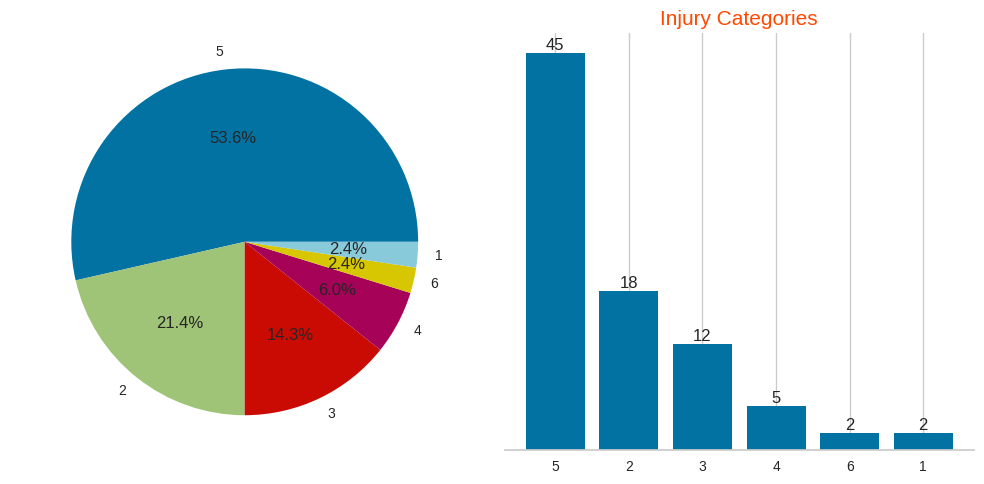

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

injury_categories = {6: '6', 5: '5', 4: '4', 3: '3', 2: '2', 1: '1'}

ax1.pie(sport_data[:]['Page'].value_counts().values, 
        labels = np.array([injury_categories[page] for page in sport_data[:]['Page'].value_counts().index]), 
        autopct = '%1.1f%%') 

ax1.axis('equal')


ax2.bar(np.array([injury_categories[page] for page in sport_data[:]['Page'].value_counts().index]), sport_data[:]['Page'].value_counts().values)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(axis='both', which='both', labelsize=10, left=False, bottom=False)
ax2.get_yaxis().set_visible(False)
plt.title("Injury Categories", fontsize=15, color = '#ff4800');

ax2.bar_label(ax2.containers[0])
fig.tight_layout()

We have to convert the nominal variables to numerical variables.

In [ ]:
pain                   = {'a': 0, 'b': 1, 'c': 2, 'd': 3}
irritability           = {'a': 0, 'b': 1, 'c':2}
severity               = {
                          'RUNNING': {'a': 0, 'b': 1, 'c': 2},
                          'LIFE_MOBILITY': {'a': 0, 'b': 1}
                        }

In [ ]:
# Pain Intensity
sport_data['Pain intensity'] = [pain[sport_data['Pain intensity'][row]] for row in range(sport_data.shape[0])]

# Irritability(WHEN, DURATION, INTENSITY)
sport_data['Irritability(WHEN)'] = [irritability[sport_data['Irritability(WHEN)'][row]] for row in range(sport_data.shape[0])]
sport_data['Irritability(DURATION)'] = [irritability[sport_data['Irritability(DURATION)'][row]] for row in range(sport_data.shape[0])]
sport_data['Irritability(INTENSITY)'] = [irritability[sport_data['Irritability(INTENSITY)'][row]] for row in range(sport_data.shape[0])]

# Severity(RUNNING)
sport_data['Severity(RUNNING)'] = [severity['RUNNING'][sport_data['Severity(RUNNING)'][row]] for row in range(sport_data.shape[0])]

# Severity(LIFE, MOBILITY)
sport_data['Severity(LIFE)'] = [severity['LIFE_MOBILITY'][sport_data['Severity(LIFE)'][row]] for row in range(sport_data.shape[0])]
sport_data['Severity(MOBILITY)'] = [severity['LIFE_MOBILITY'][sport_data['Severity(MOBILITY)'][row]] for row in range(sport_data.shape[0])]

In [ ]:
sport_data['Pain intensity']          = sport_data['Pain intensity'].astype('int64')
sport_data['Irritability(WHEN)']      = sport_data['Irritability(WHEN)'].astype('int64') 
sport_data['Irritability(DURATION)']  = sport_data['Irritability(DURATION)'].astype('int64') 
sport_data['Irritability(INTENSITY)'] = sport_data['Irritability(INTENSITY)'].astype('int64') 
sport_data['Severity(RUNNING)']       = sport_data['Severity(RUNNING)'].astype('int64') 
sport_data['Severity(LIFE)']          = sport_data['Severity(LIFE)'].astype('int64')  
sport_data['Severity(MOBILITY)']      = sport_data['Severity(MOBILITY)'].astype('int64')  

In [ ]:
sport_data.head()

,Weight,Height,Gender,Age,Experience,Symptom area,Pain intensity,Irritability(WHEN),Irritability(DURATION),Irritability(INTENSITY),Severity(RUNNING),Severity(LIFE),Severity(MOBILITY),Page
0,84,176,0,45,3.0,0,0,0,0,0,0,0,0,5
1,85,176,0,45,4.0,4,0,0,0,0,0,0,0,5
2,25,154,1,45,5.0,2,2,1,2,1,1,0,0,5
3,55,176,0,38,9.0,2,2,2,1,1,2,0,1,5
4,56,170,1,51,2.0,1,1,1,1,2,0,1,1,3


In [ ]:
sport_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Weight                   84 non-null     int64  
 1   Height                   84 non-null     int64  
 2   Gender                   84 non-null     int64  
 3   Age                      84 non-null     int64  
 4   Experience               81 non-null     float64
 5   Symptom area             84 non-null     int64  
 6   Pain intensity           84 non-null     int64  
 7   Irritability(WHEN)       84 non-null     int64  
 8   Irritability(DURATION)   84 non-null     int64  
 9   Irritability(INTENSITY)  84 non-null     int64  
 10  Severity(RUNNING)        84 non-null     int64  
 11  Severity(LIFE)           84 non-null     int64  
 12  Severity(MOBILITY)       84 non-null     int64  
 13  Page                     84 non-null     int64  
dtypes: float64(1), int64(13)
mem

In [ ]:
symptom_area = {
    'Calf': 0,
    'Hip': 1,
    'Knee': 2,
    'Low back': 3,
    'Sole': 4,
    'Thigh': 5
}
gender = {
    'Male':0,
    'Female':1
}

In [ ]:
# Run this cell and the 2 below, only if you want to keep the original dataset
sport_data['Gender'] = [gender[sport_data['Gender'][row]] for row in range(sport_data.shape[0])]
sport_data['Symptom area'] = [symptom_area[sport_data['Symptom area'][row]] for row in range(sport_data.shape[0])]

In [ ]:
sport_data['Gender']          = sport_data['Gender'].astype('int64')
sport_data['Symptom area']    = sport_data['Symptom area'].astype('int64') 

In [ ]:
sport_data.head()

,Weight,Height,Gender,Age,Experience,Symptom area,Pain intensity,Irritability(WHEN),Irritability(DURATION),Irritability(INTENSITY),Severity(RUNNING),Severity(LIFE),Severity(MOBILITY),Page
0,84,176,0,45,3.0,0,0,0,0,0,0,0,0,5
1,85,176,0,45,4.0,4,0,0,0,0,0,0,0,5
2,25,154,1,45,5.0,2,2,1,2,1,1,0,0,5
3,55,176,0,38,9.0,2,2,2,1,1,2,0,1,5
4,56,170,1,51,2.0,1,1,1,1,2,0,1,1,3


## Dataset A
(Pain intensity, Irritability(WHEN), Irritability(DURATION), Irritability(INTENSITY), Severity(RUNNING), Severity(LIFE), Severity(MOBILITY))

In [ ]:
sport_data_classification_A = sport_data.copy(deep=True)

In [ ]:
# Print the samples for class 1
sport_data_classification_A.loc[sport_data_classification_A['Page'] == 1]

,Weight,Height,Gender,Age,Experience,Symptom area,Pain intensity,Irritability(WHEN),Irritability(DURATION),Irritability(INTENSITY),Severity(RUNNING),Severity(LIFE),Severity(MOBILITY),Page
57,80,178,0,45,3.0,2,0,2,2,2,0,1,1,1
61,82,168,1,25,15.0,5,0,2,2,2,0,1,1,1
84,70,181,0,23,2.0,0,0,2,2,2,0,1,1,1
85,65,175,1,30,4.0,4,0,2,2,2,0,1,1,1
86,77,185,0,38,3.0,2,0,2,2,2,0,1,1,1
87,85,190,0,27,1.0,3,0,2,2,2,0,1,1,1


In [ ]:
# Add some additional samples for class 1.
sport_data_classification_A = pd.concat([sport_data_classification_A, pd.DataFrame([[70, 181, 0, 23, 2.0, 0, 0, 2, 2, 2, 0, 1, 1, 1]], columns=sport_data_classification_A.columns)], ignore_index = True)
sport_data_classification_A = pd.concat([sport_data_classification_A, pd.DataFrame([[65, 175, 1, 30, 4.0, 4, 0, 2, 2, 2, 0, 1, 1, 1]], columns=sport_data_classification_A.columns)], ignore_index = True)
sport_data_classification_A = pd.concat([sport_data_classification_A, pd.DataFrame([[77, 185, 0, 38, 3.0, 2, 0, 2, 2, 2, 0, 1, 1, 1]], columns=sport_data_classification_A.columns)], ignore_index = True)
sport_data_classification_A = pd.concat([sport_data_classification_A, pd.DataFrame([[85, 190, 0, 27, 1.0, 3, 0, 2, 2, 2, 0, 1, 1, 1]], columns=sport_data_classification_A.columns)], ignore_index = True)

In [ ]:
# Print the samples for class 6
sport_data_classification_A.loc[sport_data_classification_A['Page'] == 6]

,Weight,Height,Gender,Age,Experience,Symptom area,Pain intensity,Irritability(WHEN),Irritability(DURATION),Irritability(INTENSITY),Severity(RUNNING),Severity(LIFE),Severity(MOBILITY),Page
15,63,151,0,32,4.0,1,3,1,0,0,1,1,1,6
38,65,170,0,21,7.0,0,3,2,2,0,2,0,1,6
88,68,179,0,33,3.0,4,3,0,1,1,1,1,0,6
89,71,166,1,25,2.0,2,3,2,2,2,2,1,0,6
90,70,175,0,36,5.0,3,3,1,0,0,1,0,1,6
91,62,153,1,23,1.0,0,3,2,2,0,2,1,1,6


In [ ]:
# Add some additional samples for class 6.
sport_data_classification_A = pd.concat([sport_data_classification_A, pd.DataFrame([[68, 179, 0, 33, 3.0, 4, 3, 0, 1, 1, 1, 1, 0, 6]], columns=sport_data_classification_A.columns)], ignore_index = True)
sport_data_classification_A = pd.concat([sport_data_classification_A, pd.DataFrame([[71, 166, 1, 25, 2.0, 2, 3, 2, 2, 2, 2, 1, 0, 6]], columns=sport_data_classification_A.columns)], ignore_index = True)
sport_data_classification_A = pd.concat([sport_data_classification_A, pd.DataFrame([[70, 175, 0, 36, 5.0, 3, 3, 1, 0, 0, 1, 0, 1, 6]], columns=sport_data_classification_A.columns)], ignore_index = True)
sport_data_classification_A = pd.concat([sport_data_classification_A, pd.DataFrame([[62, 153, 1, 23, 1.0, 0, 3, 2, 2, 0, 2, 1, 1, 6]], columns=sport_data_classification_A.columns)], ignore_index = True)

In [ ]:
# Print the samples for class 4
sport_data_classification_A.loc[sport_data_classification_A['Page'] == 4]

,Weight,Height,Gender,Age,Experience,Symptom area,Pain intensity,Irritability(WHEN),Irritability(DURATION),Irritability(INTENSITY),Severity(RUNNING),Severity(LIFE),Severity(MOBILITY),Page
6,80,183,0,46,5.0,2,1,1,1,2,1,1,1,4
9,56,170,1,50,20.0,3,1,0,2,2,1,1,1,4
16,54,175,1,58,4.0,1,1,1,0,0,1,1,1,4
29,87,181,0,29,13.0,2,1,2,1,2,1,1,1,4
78,71,180,1,23,0.0,1,1,0,2,0,1,1,1,4
92,75,180,0,30,4.0,3,0,1,0,1,1,1,1,4


In [ ]:
# Add some additional samples for class 4.
sport_data_classification_A = pd.concat([sport_data_classification_A, pd.DataFrame([[75, 180, 0, 30, 4.0, 3, 0, 1, 0, 1, 1, 1, 1, 4]], columns=sport_data_classification_A.columns)], ignore_index = True)

## Dataset B
(PAIN, IRRITABILITY, SEVERITY)

In [ ]:
data = {
    'Weight': list(sport_data['Weight'][:]),
    'height': list(sport_data['Height'][:]),
    'Gender': list(sport_data['Gender'][:]),
    'Age': list(sport_data['Age'][:]),
    'Experience': list(sport_data['Experience'][:]),
    'Symptom area': list(sport_data['Symptom area'][:]),
    'PAIN': [],
    'IRRITABILITY': [],
    'SEVERITY': [],
    'Page': list(sport_data['Page'][:]),
}

for row in range(sport_data.shape[0]):
  factor_list = create_main_factor_list(sport_data.iloc[row], 6)
  data['PAIN'].append(factor_list[0])
  data['IRRITABILITY'].append(factor_list[1])
  data['SEVERITY'].append(factor_list[2])


# Create a new dataframe for classification
sport_data_classification_B = pd.DataFrame(data=data)

In [ ]:
sport_data_classification_B.head()

,Weight,height,Gender,Age,Experience,Symptom area,PAIN,IRRITABILITY,SEVERITY,Page
0,84,176,0,45,3.0,0,0,2,2,5
1,85,176,0,45,4.0,4,0,2,2,5
2,25,154,1,45,5.0,2,2,1,2,5
3,55,176,0,38,9.0,2,2,1,2,5
4,56,170,1,51,2.0,1,1,1,0,3


In [ ]:
data = {
    'Weight': list(sport_data_classification_A['Weight'][:]),
    'height': list(sport_data_classification_A['Height'][:]),
    'Gender': list(sport_data_classification_A['Gender'][:]),
    'Age': list(sport_data_classification_A['Age'][:]),
    'Experience': list(sport_data_classification_A['Experience'][:]),
    'Symptom area': list(sport_data_classification_A['Symptom area'][:]),
    'PAIN': [],
    'IRRITABILITY': [],
    'SEVERITY': [],
    'Page': list(sport_data_classification_A['Page'][:]),
}

for row in range(sport_data_classification_A.shape[0]):
  factor_list = create_main_factor_list(sport_data_classification_A.iloc[row], 6)
  data['PAIN'].append(factor_list[0])
  data['IRRITABILITY'].append(factor_list[1])
  data['SEVERITY'].append(factor_list[2])


# Create a new dataframe for classification
sport_data_classification_B_altered = pd.DataFrame(data=data)

In [ ]:
sport_data_classification_B_altered.shape

(93, 10)

# Classification

## Classification Helper Functions

In [ ]:
def show_decision_tree_classifier(model, features):
  dot_data = StringIO()
  export_graphviz(model, 
                  out_file=dot_data,  
                  filled=True, 
                  rounded=True,
                  special_characters=True,
                  feature_names=features,
                  class_names=['1', '2', '3', '4', '5', '6'])

  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
  graph.write_png('DecisionTree.png')

  return graph


In [ ]:
def create_clusters(labels, dataframe):
  clusters = [[] for _ in range(len(np.unique(labels)))]
  
  for label_index in range(len(labels)):
    clusters[labels[label_index]].append(dataframe.iloc[label_index]['Age'])
  
  return clusters

## Decision Trees


Scikit-learn uses an optimized version of the CART algorithm and the implementation does not support categorical variables.

CART (Classification and Regression Trees) is very similar to C4.5, but it differs in that it supports numerical target variables (regression) and does not compute rule sets. CART constructs binary trees using the feature and threshold that yield the largest information gain at each node.

C4.5 is the successor to ID3 and removed the restriction that features must be categorical by dynamically defining a discrete attribute (based on numerical variables) that partitions the continuous attribute value into a discrete set of intervals. C4.5 converts the trained trees (i.e. the output of the ID3 algorithm) into sets of if-then rules. The accuracy of each rule is then evaluated to determine the order in which they should be applied. Pruning is done by removing a rule's precondition if the accuracy of the rule improves without it.

ID3 (Iterative Dichotomiser 3) was developed in 1986 by Ross Quinlan. The algorithm creates a multiway tree, finding for each node (i.e. in a greedy manner) the categorical feature that will yield the largest information gain for categorical targets. Trees are grown to their maximum size and then a pruning step is usually applied to improve the ability of the tree to generalize to unseen data.

### Decision Tree Classifier 1

Decision tree classifier for three features of the dataset.  

- PAIN
- IRRITABILITY
- SEVERITY

We test the classifier for a list of splitting percentage values.

In [ ]:
# Classification data based on the unaltered original dataset
classification_data = sport_data_classification_B[['PAIN', 'IRRITABILITY', 'SEVERITY', 'Page']]

In [ ]:
# Classification data based on the altered original dataset
classification_data_altered = sport_data_classification_B_altered[['PAIN', 'IRRITABILITY', 'SEVERITY', 'Page']]

In [ ]:
# Testing for the unaltered original dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(classification_data, test_size=perc_value, random_state=1, stratify=classification_data.Page)

  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(train[['PAIN', 'IRRITABILITY', 'SEVERITY']], train['Page'])

  # Predict the response for test dataset
  y_pred = clf.predict(test[['PAIN', 'IRRITABILITY', 'SEVERITY']])
  
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[perc_value] = [f_score, clf]

  print(f'Test Size: {perc_value}, F-Score: {f_score}')

Test Size: 0.1, F-Score: 1.0
Test Size: 0.15000000000000002, F-Score: 1.0
Test Size: 0.20000000000000004, F-Score: 1.0
Test Size: 0.25000000000000006, F-Score: 0.9327272727272728
Test Size: 0.30000000000000004, F-Score: 0.9429708222811671
Test Size: 0.3500000000000001, F-Score: 0.9505050505050505
Test Size: 0.40000000000000013, F-Score: 0.9562798092209858
Test Size: 0.45000000000000007, F-Score: 0.9608472400513479
Test Size: 0.5000000000000001, F-Score: 0.9653636813458684


In [ ]:
# Testing for the altered original dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(classification_data_altered, test_size=perc_value, random_state=1, stratify=classification_data_altered.Page)

  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(train[['PAIN', 'IRRITABILITY', 'SEVERITY']], train['Page'])

  # Predict the response for test dataset
  y_pred = clf.predict(test[['PAIN', 'IRRITABILITY', 'SEVERITY']])
  
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[perc_value] = [f_score, clf]

  print(f'Test Size: {perc_value}, F-Score: {f_score}')

Test Size: 0.1, F-Score: 1.0
Test Size: 0.15000000000000002, F-Score: 1.0
Test Size: 0.20000000000000004, F-Score: 1.0
Test Size: 0.25000000000000006, F-Score: 0.9136865549909029
Test Size: 0.30000000000000004, F-Score: 0.9255122655122656
Test Size: 0.3500000000000001, F-Score: 0.9365482784837624
Test Size: 0.40000000000000013, F-Score: 0.9464342674868991
Test Size: 0.45000000000000007, F-Score: 0.9514772808890455
Test Size: 0.5000000000000001, F-Score: 0.9564609833366832


#### Classification with SMOTE for the Altered Dataset

In [ ]:
# Resample the altered original dataset
new_altered_classification_data = classification_data_altered.copy()
resampled_data = SMOTE().fit_resample(new_altered_classification_data[['PAIN', 'IRRITABILITY', 'SEVERITY']], new_altered_classification_data['Page'])
new_altered_classification_data = resampled_data[0]
new_altered_classification_data['Page'] = resampled_data[1].to_numpy()

In [ ]:
# Check for misclassified samples
for sample_row in range(new_altered_classification_data.shape[0]):
  page = classify_sample(new_altered_classification_data.iloc[sample_row], 0)
  if new_altered_classification_data.iloc[sample_row]['Page'] != page:
    print(f'Misclassified Sample: {sample_row}')

In [ ]:
# Check if there are any identical combinations between the two classifications
unique_samples = np.unique(new_altered_classification_data.to_numpy(), axis=0).shape[0]
identical_samples = 0
for new_sample in np.unique(new_altered_classification_data.to_numpy(), axis=0):
  for original_sample in np.unique(classification_data_altered.to_numpy(), axis=0):
    if (new_sample == original_sample).all():
      identical_samples += 1
      break
      
print(f'Unique samples in new classification data: {unique_samples}. Identical samples: {identical_samples}')

Unique samples in new classification data: 18. Identical samples: 17


In [ ]:
# Training set will be the SMOTE resampled altered original dataset
train = new_altered_classification_data

# Testing set will be the original dataset
test = classification_data

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(train[['PAIN', 'IRRITABILITY', 'SEVERITY']], train['Page'])

# Predict the response for test dataset
y_pred = clf.predict(test[['PAIN', 'IRRITABILITY', 'SEVERITY']])

print(classification_report(test['Page'], y_pred, zero_division=0))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00        45
           6       1.00      1.00      1.00         2

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



In [ ]:
# Testing for the SMOTE resampled altered dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(new_altered_classification_data, test_size=perc_value, random_state=1, stratify=new_altered_classification_data.Page)

  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(train[['PAIN', 'IRRITABILITY', 'SEVERITY']], train['Page'])

  # Predict the response for test dataset
  y_pred = clf.predict(test[['PAIN', 'IRRITABILITY', 'SEVERITY']])
  
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[perc_value] = [f_score, clf]

  print(f'Test Size: {perc_value}, F-Score: {f_score}')

Test Size: 0.1, F-Score: 1.0
Test Size: 0.15000000000000002, F-Score: 1.0
Test Size: 0.20000000000000004, F-Score: 1.0
Test Size: 0.25000000000000006, F-Score: 1.0
Test Size: 0.30000000000000004, F-Score: 0.9878048780487805
Test Size: 0.3500000000000001, F-Score: 0.9894736842105263
Test Size: 0.40000000000000013, F-Score: 0.9908186036626403
Test Size: 0.45000000000000007, F-Score: 0.9917981525338583
Test Size: 0.5000000000000001, F-Score: 0.9926470588235294


### Decision Tree Classifier 2
Decision tree classifier for five features of the dataset.  

- Age
- Symptom Area
- PAIN
- IRRITABILITY
- SEVERITY

We test the classifier for a predefined splitting percentage value.

In [ ]:
# Classification data based on the original dataset
classification_data = sport_data_classification[['Age', 'Symptom area', 'PAIN', 'IRRITABILITY', 'SEVERITY', 'Page']]

In [ ]:
# Sort the ages
sorted_ages = np.sort(np.array(list(classification_data['Age'])))
print(sorted_ages)

[16 17 19 21 21 23 23 25 25 25 25 25 25 25 26 29 32 33 34 37 38 38 39 40
 41 41 42 44 44 44 45 45 45 45 45 45 45 45 45 45 45 45 45 46 46 46 46 46
 46 46 46 48 48 48 48 49 50 50 50 50 50 50 50 50 51 51 51 52 53 54 55 55
 55 56 56 57 58 58 58 60 60 60 61 65]


#### Clustering

The maximum age in the dataset is 65, the minimum is 16, and there are 84 samples. In order to acquire a high accuracy classification model, the values of the "Age" feature must be grouped. Clustering methods can help with this particular task. Before clustering, the optimal number of clusters must be found. Therefore, the Elbow method is used. To use the elbow method, the maximum and minimum number of clusters must be defined. The minimum number of clusters will be 2, and the maximum will be 49(65 - 16) due to the fact that each age can have a unique cluster accosiated with it.

In [ ]:
cluster_data = np.array(list(classification_data['Age']))
cluster_data = np.reshape(cluster_data, (cluster_data.shape[0], 1))

In [ ]:
print("Max Age: {max_age}".format(max_age = max(list(classification_data['Age']))))
print("Min Age: {min_age}".format(min_age = min(list(classification_data['Age']))))

Max Age: 65
Min Age: 16


/usr/local/lib/python3.10/dist-packages/yellowbrick/cluster/elbow.py:339: ConvergenceWarning: Number of distinct clusters (34) found smaller than n_clusters (35). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/usr/local/lib/python3.10/dist-packages/yellowbrick/cluster/elbow.py:339: ConvergenceWarning: Number of distinct clusters (34) found smaller than n_clusters (36). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/usr/local/lib/python3.10/dist-packages/yellowbrick/cluster/elbow.py:339: ConvergenceWarning: Number of distinct clusters (34) found smaller than n_clusters (37). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/usr/local/lib/python3.10/dist-packages/yellowbrick/cluster/elbow.py:339: ConvergenceWarning: Number of distinct clusters (34) found smaller than n_clusters (38). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/usr/local/lib/python3.10/dist-packages/yellowbrick/clus

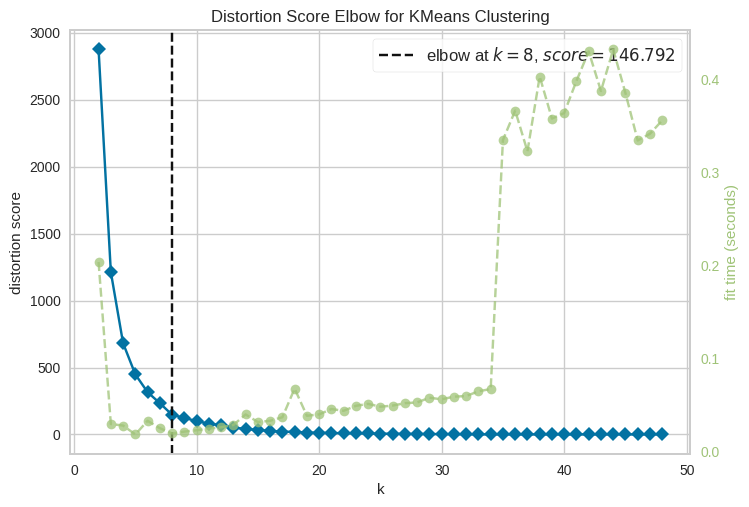

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Apply the elbow method
kmeans_elbow_method = KMeans(init='k-means++', n_init=10)
kmeans_elbow_visualizer = KElbowVisualizer(kmeans_elbow_method, k=(2, 49))

kmeans_elbow_visualizer.fit(cluster_data)
kmeans_elbow_visualizer.show()

In [ ]:
kmeans = KMeans(n_clusters=8, n_init=10)
kmeans_labels = kmeans.fit_predict(cluster_data)

In [ ]:
kmeans_clusters = create_clusters(kmeans_labels, classification_data)

In [ ]:
age_groups = []
for cluster in kmeans_clusters:
  age_groups.append([min(cluster), max(cluster)])

age_groups.sort(key = lambda cluster: cluster[0])

In [ ]:
age_groups

[[16, 21],
 [23, 26],
 [29, 34],
 [37, 42],
 [44, 46],
 [48, 52],
 [53, 58],
 [60, 65]]

#### Classification

In [ ]:
# Define age group boundaries
bins = []

for age_group in age_groups:
  bins.append(age_group[0])

bins.append(age_groups[-1][1])

In [ ]:
bins

[16, 23, 29, 37, 44, 48, 53, 58, 65]

In [ ]:
classification_data['Age'] = pd.cut(classification_data['Age'], bins, include_lowest=True,labels=list(range(0,8)))

<ipython-input-71-ce2644d7bde4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_data['Age'] = pd.cut(classification_data['Age'], bins, include_lowest=True,labels=list(range(0,8)))


In [ ]:
classification_data.head()

,Age,Symptom area,PAIN,IRRITABILITY,SEVERITY,Page
0,4,0,0,2,2,5
1,4,4,0,2,2,5
2,4,2,2,1,2,5
3,3,2,2,1,2,5
4,5,1,1,1,0,3


In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Split dataset into training set and test set
train, test = train_test_split(classification_data, test_size=0.3, random_state=1, stratify=classification_data.Page)

# Train Decision Tree Classifer
clf = clf.fit(train[['Age', 'Symptom area', 'PAIN', 'IRRITABILITY', 'SEVERITY']], train['Page'])

# Predict the response for test dataset
y_pred = clf.predict(test[['Age', 'Symptom area', 'PAIN', 'IRRITABILITY', 'SEVERITY']])

print(classification_report(test['Page'], y_pred, zero_division=0))

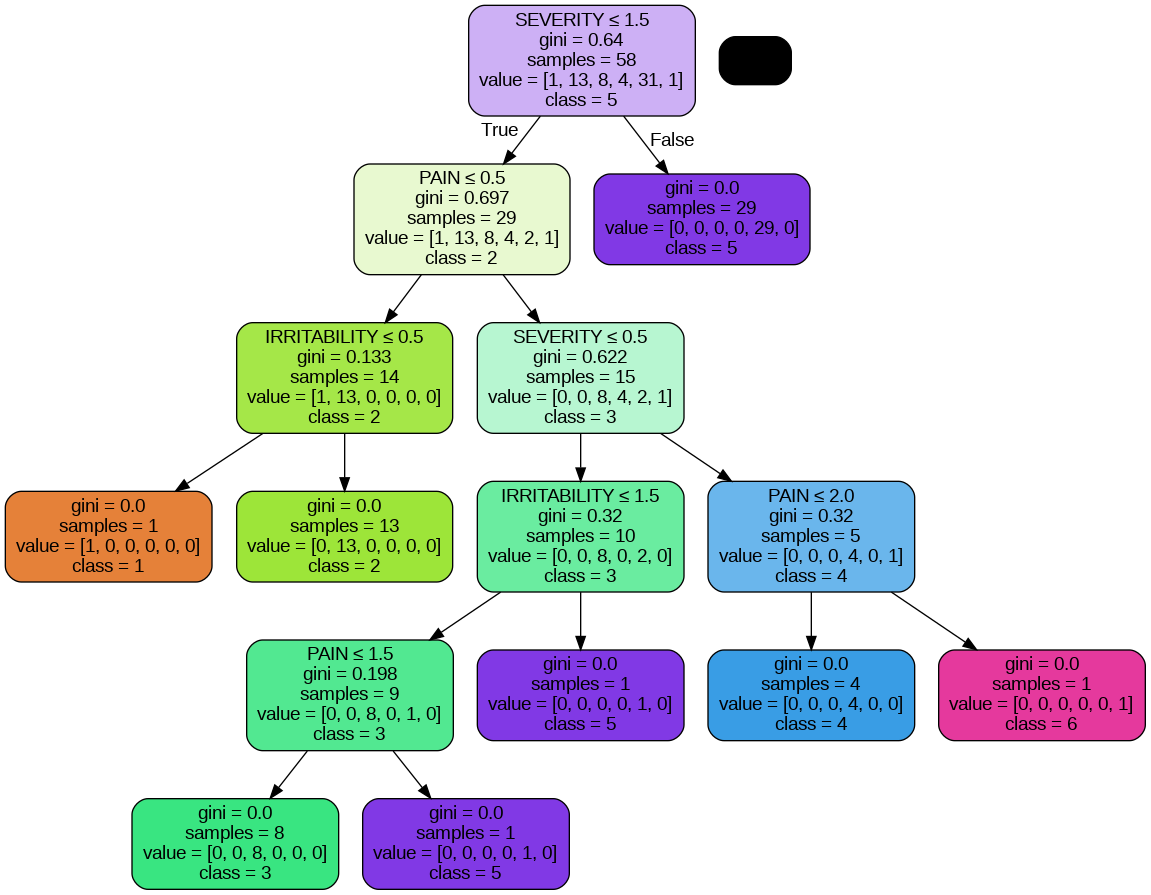

In [ ]:
Image(show_decision_tree_classifier(clf, ['Age', 'Symptom Area', 'PAIN', 'IRRITABILITY', 'SEVERITY']).create_png())

### Decision Tree Classifier 3
Decision tree classifier for five features of the dataset.  

- Weight
- Height
- Gender
- Age
- Running Experience
- Symptom Area

We test the classifier for a predefined splitting percentage value.

In [ ]:
# Classification data based on the original dataset
classification_data = sport_data_classification[['Weight', 'height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Page']]

In [ ]:
# Drop the samples that contain null values
classification_data = classification_data.dropna()

In [ ]:
pd.DataFrame(classification_data.isnull().sum(), columns=["No. Missing Values"])

,No. Missing Values
Weight,0
height,0
Gender,0
Age,0
Experience,0
Symptom area,0
Page,0


In [ ]:
# Show the class imbalance between injury categories
classification_data.pivot_table(index='Page', aggfunc='size')

Page
1     2
2    18
3    12
4     5
5    42
6     2
dtype: int64

In [ ]:
# Split dataset into training set and test set. Stratified sampling will force the same class balance on the train and test dataset as the original data.
train, test = train_test_split(classification_data, test_size=0.30, random_state=1, stratify=classification_data.Page)

In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(train[['Weight', 'height', 'Gender', 'Age', 'Experience', 'Symptom area']], train['Page'])

# Predict the response for test dataset
y_pred = clf.predict(test[['Weight', 'height', 'Gender', 'Age', 'Experience', 'Symptom area']])

In [ ]:
print(classification_report(test['Page'], y_pred, zero_division=0))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.14      0.20      0.17         5
           3       0.50      0.25      0.33         4
           4       0.00      0.00      0.00         1
           5       0.50      0.38      0.43        13
           6       0.00      0.00      0.00         1

    accuracy                           0.28        25
   macro avg       0.19      0.14      0.16        25
weighted avg       0.37      0.28      0.31        25



#### Classification with SMOTE

In [ ]:
k_neighbors = [1, 4, 5]
sampling_strategy = [{1: 42, 6:42}, {4: 42}, 'auto']

new_classification_data = classification_data.copy()
for i in range(3):
  classification_data_resampled = SMOTE(k_neighbors=k_neighbors[i], sampling_strategy=sampling_strategy[i]).fit_resample(new_classification_data[['Weight', 'height', 'Gender', 'Age', 'Experience', 'Symptom area']], new_classification_data['Page'])
  new_classification_data = classification_data_resampled[0]
  new_classification_data['Page'] = classification_data_resampled[1].to_numpy()

In [ ]:
# Check if there are any identical combinations between the two classifications
unique_samples = np.unique(new_classification_data.to_numpy(), axis=0).shape[0]
identical_samples = 0
for new_sample in np.unique(new_classification_data.to_numpy(), axis=0):
  for original_sample in np.unique(classification_data.to_numpy(), axis=0):
    if (new_sample == original_sample).all():
      identical_samples += 1
      break
      
print(f'Unique samples in new classification data: {unique_samples}. Identical samples: {identical_samples}')

Unique samples in new classification data: 250. Identical samples: 81


In [ ]:
# Training set will be the SMOTE resampled original dataset
train = new_classification_data

# Testing will be the original dataset
test = classification_data

In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(train[['Weight', 'height', 'Gender', 'Age', 'Experience', 'Symptom area']], train['Page'])

# Predict the response for test dataset
y_pred = clf.predict(test[['Weight', 'height', 'Gender', 'Age', 'Experience', 'Symptom area']])

In [ ]:
print(classification_report(test['Page'], y_pred, zero_division=0))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      0.94      0.97        18
           3       0.92      1.00      0.96        12
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00        42
           6       1.00      1.00      1.00         2

    accuracy                           0.99        81
   macro avg       0.99      0.99      0.99        81
weighted avg       0.99      0.99      0.99        81



In [ ]:
# Training and testing on the SMOTE resampled original dataset
train, test = train_test_split(new_classification_data, test_size=0.30, random_state=1, stratify=new_classification_data.Page)

In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(train[['Weight', 'height', 'Gender', 'Age', 'Experience', 'Symptom area']], train['Page'])

# Predict the response for test dataset
y_pred = clf.predict(test[['Weight', 'height', 'Gender', 'Age', 'Experience', 'Symptom area']])

In [ ]:
print(classification_report(test['Page'], y_pred, zero_division=0))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        13
           2       0.22      0.33      0.27        12
           3       0.67      0.50      0.57        12
           4       1.00      0.62      0.76        13
           5       0.43      0.46      0.44        13
           6       0.93      1.00      0.96        13

    accuracy                           0.66        76
   macro avg       0.71      0.65      0.67        76
weighted avg       0.71      0.66      0.67        76



### Decision Tree Classifier 4
Decision tree classifier for 7 features of the dataset.  

- PAIN
- IRRITABILITY(WHEN)
- IRRITABILITY(DURATION)
- IRRITABILITY(INTENSITY)
- SEVERITY(RUNNING)
- SEVERITY(LIFE)
- SEVERITY(MOBILITY)

We test the classifier for a list of splitting percentage values.

In [ ]:
# Classification data based on the unaltered original dataset
classification_data = sport_data[['Pain intensity', 
                                  'Irritability(WHEN)', 
                                  'Irritability(DURATION)', 
                                  'Irritability(INTENSITY)', 
                                  'Severity(RUNNING)', 
                                  'Severity(LIFE)', 
                                  'Severity(MOBILITY)',
                                  'Page']]

In [ ]:
# Classification data based on the altered original dataset
classification_data_altered = sport_data_classification_A[['Pain intensity', 
                                  'Irritability(WHEN)', 
                                  'Irritability(DURATION)', 
                                  'Irritability(INTENSITY)', 
                                  'Severity(RUNNING)', 
                                  'Severity(LIFE)', 
                                  'Severity(MOBILITY)',
                                  'Page']]

In [ ]:
# Testing for the unaltered original dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(classification_data, test_size=perc_value, random_state=1, stratify=classification_data.Page)

  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(train[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']], train['Page'])

  # Predict the response for test dataset
  y_pred = clf.predict(test[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']])
  
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[round(perc_value,2)] = [f_score, clf]

  print(f'Test Size: {perc_value}, F-Score: {f_score}')

Test Size: 0.1, F-Score: 1.0
Test Size: 0.15000000000000002, F-Score: 1.0
Test Size: 0.20000000000000004, F-Score: 1.0
Test Size: 0.25000000000000006, F-Score: 0.9327272727272728
Test Size: 0.30000000000000004, F-Score: 0.9429708222811671
Test Size: 0.3500000000000001, F-Score: 0.9505050505050505
Test Size: 0.40000000000000013, F-Score: 0.9562798092209858
Test Size: 0.45000000000000007, F-Score: 0.9608472400513479
Test Size: 0.5000000000000001, F-Score: 0.9773802424965216


In [ ]:
# Testing for the altered original dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(classification_data_altered, test_size=perc_value, random_state=1, stratify=classification_data_altered.Page)

  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(train[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']], train['Page'])

  # Predict the response for test dataset
  y_pred = clf.predict(test[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']])
  
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[round(perc_value,2)] = [f_score, clf]

  print(f'Test Size: {perc_value}, F-Score: {f_score}')

Test Size: 0.1, F-Score: 0.9044444444444444
Test Size: 0.15000000000000002, F-Score: 0.9377289377289377
Test Size: 0.20000000000000004, F-Score: 0.9545923632610939
Test Size: 0.25000000000000006, F-Score: 0.8741883116883117
Test Size: 0.30000000000000004, F-Score: 0.8918650793650793
Test Size: 0.3500000000000001, F-Score: 0.9074915824915825
Test Size: 0.40000000000000013, F-Score: 0.9213587109484943
Test Size: 0.45000000000000007, F-Score: 0.9286650970861497
Test Size: 0.5000000000000001, F-Score: 0.8966597232554679


#### Classification with SMOTE for the Altered Dataset

In [ ]:
# Resample the altered original dataset
new_altered_classification_data = classification_data_altered.copy()
resampled_data = SMOTE().fit_resample(new_altered_classification_data[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']], new_altered_classification_data['Page'])
new_altered_classification_data = resampled_data[0]
new_altered_classification_data['Page'] = resampled_data[1].to_numpy()

In [ ]:
# Check for misclassified samples
for sample_row in range(new_altered_classification_data.shape[0]):
  factor_list = create_main_factor_list(new_altered_classification_data.iloc[sample_row], 0)
  page = classify_sample(factor_list)
  if new_altered_classification_data.iloc[sample_row]['Page'] != page:
    print(f'Misclassified Sample: {sample_row}')

In [ ]:
# Check if there are any identical combinations between the two classifications
unique_samples = np.unique(new_altered_classification_data.to_numpy(), axis=0).shape[0]
identical_samples = 0
for new_sample in np.unique(new_altered_classification_data.to_numpy(), axis=0):
  for original_sample in np.unique(classification_data_altered.to_numpy(), axis=0):
    if (new_sample == original_sample).all():
      identical_samples += 1
      break
      
print(f'Unique samples in new classification data: {unique_samples}. Identical samples: {identical_samples}')

Unique samples in new classification data: 93. Identical samples: 68


In [ ]:
# Training set will be the SMOTE resampled altered original dataset
train = new_altered_classification_data

# Testing set will be the original dataset
test = classification_data

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(train[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']], train['Page'])

# Predict the response for test dataset
y_pred = clf.predict(test[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']])

print(classification_report(test['Page'], y_pred, zero_division=0))

In [ ]:
# Testing for the SMOTE resampled altered dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(new_altered_classification_data, test_size=perc_value, random_state=1, stratify=new_altered_classification_data.Page)

  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(train[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']], train['Page'])

  # Predict the response for test dataset
  y_pred = clf.predict(test[['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']])
  
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[round(perc_value,2)] = [f_score, clf]

  print(f'Test Size: {perc_value}, F-Score: {f_score}')

Test Size: 0.1, F-Score: 1.0
Test Size: 0.15000000000000002, F-Score: 0.9754846779237022
Test Size: 0.20000000000000004, F-Score: 0.9817618913594146
Test Size: 0.25000000000000006, F-Score: 0.9852636706856657
Test Size: 0.30000000000000004, F-Score: 0.9751233409769995
Test Size: 0.3500000000000001, F-Score: 0.9785748829551886
Test Size: 0.40000000000000013, F-Score: 0.9813596651157364
Test Size: 0.45000000000000007, F-Score: 0.983375071024222
Test Size: 0.5000000000000001, F-Score: 0.9851232917409388


In [ ]:
Image(show_decision_tree_classifier(model_score[0.30][1], ['Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']).create_png())

### Decision Tree Classifier 5
Decision tree classifier for all features of the dataset.  

- Weight
- Height
- Gender
- Age
- Experience
- Symptom area
- PAIN
- IRRITABILITY(WHEN)
- IRRITABILITY(DURATION)
- IRRITABILITY(INTENSITY)
- SEVERITY(RUNNING)
- SEVERITY(LIFE)
- SEVERITY(MOBILITY)

We test the classifier for a list of splitting percentage values.

In [ ]:
# Classification data based on the unaltered original dataset
classification_data = sport_data

classification_data = classification_data.dropna()

In [ ]:
# Classification data based on the altered original dataset
classification_data_altered = sport_data_classification_A

classification_data_altered = classification_data_altered.dropna()

In [ ]:
# Testing for the unaltered original dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(classification_data, test_size=perc_value, random_state=1, stratify=classification_data.Page)

  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(train[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']], train['Page'])

  # Predict the response for test dataset
  y_pred = clf.predict(test[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']])
  
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[round(perc_value,2)] = [f_score, clf]

  print(f'Test Size: {perc_value}, F-Score: {f_score}')

Test Size: 0.1, F-Score: 1.0
Test Size: 0.15000000000000002, F-Score: 1.0
Test Size: 0.20000000000000004, F-Score: 0.9663865546218489
Test Size: 0.25000000000000006, F-Score: 0.9031515988037727
Test Size: 0.30000000000000004, F-Score: 0.9051851851851852
Test Size: 0.3500000000000001, F-Score: 0.9488320355951056
Test Size: 0.40000000000000013, F-Score: 0.8943722943722943
Test Size: 0.45000000000000007, F-Score: 0.8936936936936936
Test Size: 0.5000000000000001, F-Score: 0.9189199131810322


In [ ]:
# Testing for the altered original dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(classification_data_altered, test_size=perc_value, random_state=1, stratify=classification_data_altered.Page)

  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(train[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']], train['Page'])

  # Predict the response for test dataset
  y_pred = clf.predict(test[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']])
  
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[round(perc_value,2)] = [f_score, clf]

  print(f'Test Size: {perc_value}, F-Score: {f_score}')

Test Size: 0.1, F-Score: 0.8994708994708994
Test Size: 0.15000000000000002, F-Score: 0.9304267161410019
Test Size: 0.20000000000000004, F-Score: 0.8178288859403411
Test Size: 0.25000000000000006, F-Score: 0.7323199302604336
Test Size: 0.30000000000000004, F-Score: 0.6928571428571428
Test Size: 0.3500000000000001, F-Score: 0.8431919642857142
Test Size: 0.40000000000000013, F-Score: 0.8558558558558558
Test Size: 0.45000000000000007, F-Score: 0.7965771674523467
Test Size: 0.5000000000000001, F-Score: 0.7557710405536493


#### Classification with SMOTE for the Altered Dataset

In [ ]:
# Resample the altered original dataset
new_altered_classification_data = classification_data_altered.copy()
resampled_data = SMOTE().fit_resample(new_altered_classification_data[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']], new_altered_classification_data['Page'])
new_altered_classification_data = resampled_data[0]
new_altered_classification_data['Page'] = resampled_data[1].to_numpy()

In [ ]:
# Check for misclassified samples
for sample_row in range(new_altered_classification_data.shape[0]):
  factor_list = create_main_factor_list(new_altered_classification_data.iloc[sample_row], 6)
  page = classify_sample(factor_list)
  if new_altered_classification_data.iloc[sample_row]['Page'] != page:
    print(f'Misclassified Sample: {sample_row}')

In [ ]:
# Check if there are any identical combinations between the two classifications
unique_samples = np.unique(new_altered_classification_data.to_numpy(), axis=0).shape[0]
identical_samples = 0
for new_sample in np.unique(new_altered_classification_data.to_numpy(), axis=0):
  for original_sample in np.unique(classification_data_altered.to_numpy(), axis=0):
    if (new_sample == original_sample).all():
      identical_samples += 1
      break
      
print(f'Unique samples in new classification data: {unique_samples}. Identical samples: {identical_samples}')

Unique samples in new classification data: 249. Identical samples: 90


In [ ]:
# Training set will be the SMOTE resampled altered original dataset
train = new_altered_classification_data

# Testing set will be the original dataset
test = classification_data

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(train[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']], train['Page'])

# Predict the response for test dataset
y_pred = clf.predict(test[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']])

print(classification_report(test['Page'], y_pred, zero_division=0))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00        42
           6       1.00      1.00      1.00         2

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81



In [ ]:
# Testing for the SMOTE resampled altered dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(new_altered_classification_data, test_size=perc_value, random_state=1, stratify=new_altered_classification_data.Page)

  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(train[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']], train['Page'])

  # Predict the response for test dataset
  y_pred = clf.predict(test[['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']])
  
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[round(perc_value,2)] = [f_score, clf]

  print(f'Test Size: {perc_value}, F-Score: {f_score}')

Test Size: 0.1, F-Score: 0.9145299145299146
Test Size: 0.15000000000000002, F-Score: 0.8628257707205074
Test Size: 0.20000000000000004, F-Score: 0.8601176142971809
Test Size: 0.25000000000000006, F-Score: 0.9207108680792891
Test Size: 0.30000000000000004, F-Score: 0.8751044277360066
Test Size: 0.3500000000000001, F-Score: 0.9431594982612967
Test Size: 0.40000000000000013, F-Score: 0.9400852585258526
Test Size: 0.45000000000000007, F-Score: 0.9559265711704735
Test Size: 0.5000000000000001, F-Score: 0.9524318210483729


In [ ]:
Image(show_decision_tree_classifier(model_score[0.30][1], ['Weight', 'Height', 'Gender', 'Age', 'Experience', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']).create_png())

### Decision Tree Classifier 6
Decision tree classifier for 9 features of the dataset.  

- Age
- Symptom area
- PAIN
- IRRITABILITY(WHEN)
- IRRITABILITY(DURATION)
- IRRITABILITY(INTENSITY)
- SEVERITY(RUNNING)
- SEVERITY(LIFE)
- SEVERITY(MOBILITY)

We test the classifier for a list of splitting percentage values.

In [ ]:
# Classification data based on the unaltered original dataset
classification_data = sport_data[['Age',
                                  'Symptom area',
                                  'Pain intensity', 
                                  'Irritability(WHEN)', 
                                  'Irritability(DURATION)', 
                                  'Irritability(INTENSITY)', 
                                  'Severity(RUNNING)', 
                                  'Severity(LIFE)', 
                                  'Severity(MOBILITY)',
                                  'Page']]

In [ ]:
# Classification data based on the altered original dataset
classification_data_altered = sport_data_classification_A[[
                                  'Age',
                                  'Symptom area',
                                  'Pain intensity', 
                                  'Irritability(WHEN)', 
                                  'Irritability(DURATION)', 
                                  'Irritability(INTENSITY)', 
                                  'Severity(RUNNING)', 
                                  'Severity(LIFE)', 
                                  'Severity(MOBILITY)',
                                  'Page']]

In [ ]:
# Testing for the unaltered original dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(classification_data, test_size=perc_value, random_state=1, stratify=classification_data.Page)

  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(train[['Age', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']], train['Page'])

  # Predict the response for test dataset
  y_pred = clf.predict(test[['Age', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']])
  
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[round(perc_value,2)] = [f_score, clf]

  print(f'Test Size: {perc_value}, F-Score: {f_score}')

Test Size: 0.1, F-Score: 1.0
Test Size: 0.15000000000000002, F-Score: 1.0
Test Size: 0.20000000000000004, F-Score: 0.9338235294117647
Test Size: 0.25000000000000006, F-Score: 0.9327272727272728
Test Size: 0.30000000000000004, F-Score: 0.8660477453580901
Test Size: 0.3500000000000001, F-Score: 0.9505050505050505
Test Size: 0.40000000000000013, F-Score: 0.9072602013778485
Test Size: 0.45000000000000007, F-Score: 0.9082156611039796
Test Size: 0.5000000000000001, F-Score: 0.9321407274895647


In [ ]:
# Testing for the altered original dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(classification_data_altered, test_size=perc_value, random_state=1, stratify=classification_data_altered.Page)

  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(train[['Age', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']], train['Page'])

  # Predict the response for test dataset
  y_pred = clf.predict(test[['Age', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']])
  
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[round(perc_value,2)] = [f_score, clf]

  print(f'Test Size: {perc_value}, F-Score: {f_score}')

Test Size: 0.1, F-Score: 0.9111111111111111
Test Size: 0.15000000000000002, F-Score: 0.9377289377289377
Test Size: 0.20000000000000004, F-Score: 0.9487444100447197
Test Size: 0.25000000000000006, F-Score: 0.8741883116883117
Test Size: 0.30000000000000004, F-Score: 0.8510317460317459
Test Size: 0.3500000000000001, F-Score: 0.7822390572390572
Test Size: 0.40000000000000013, F-Score: 0.8186884323107233
Test Size: 0.45000000000000007, F-Score: 0.8154515075567708
Test Size: 0.5000000000000001, F-Score: 0.8170797287818564


#### Classification with SMOTE for the Altered Dataset

In [ ]:
# Resample the altered original dataset
new_altered_classification_data = classification_data_altered.copy()
resampled_data = SMOTE().fit_resample(new_altered_classification_data[['Age', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']], new_altered_classification_data['Page'])
new_altered_classification_data = resampled_data[0]
new_altered_classification_data['Page'] = resampled_data[1].to_numpy()

In [ ]:
# Check for misclassified samples
for sample_row in range(new_altered_classification_data.shape[0]):
  factor_list = create_main_factor_list(new_altered_classification_data.iloc[sample_row], 2)
  page = classify_sample(factor_list)
  if new_altered_classification_data.iloc[sample_row]['Page'] != page:
    print(f'Misclassified Sample: {sample_row}')

In [ ]:
# Check if there are any identical combinations between the two classifications
unique_samples = np.unique(new_altered_classification_data.to_numpy(), axis=0).shape[0]
identical_samples = 0
for new_sample in np.unique(new_altered_classification_data.to_numpy(), axis=0):
  for original_sample in np.unique(classification_data_altered.to_numpy(), axis=0):
    if (new_sample == original_sample).all():
      identical_samples += 1
      break
      
print(f'Unique samples in new classification data: {unique_samples}. Identical samples: {identical_samples}')

Unique samples in new classification data: 214. Identical samples: 90


In [ ]:
# Training set will be the SMOTE resampled altered original dataset
train = new_altered_classification_data

# Testing set will be the original dataset
test = classification_data

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(train[['Age', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']], train['Page'])

# Predict the response for test dataset
y_pred = clf.predict(test[['Age', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']])

print(classification_report(test['Page'], y_pred, zero_division=0))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00        45
           6       1.00      1.00      1.00         2

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



In [ ]:
# Testing for the SMOTE resampled altered dataset

model_score = {}
for perc_value in list(np.arange(0.1, 0.55, 0.05)):
  train, test = train_test_split(new_altered_classification_data, test_size=perc_value, random_state=1, stratify=new_altered_classification_data.Page)

  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(train[['Age', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']], train['Page'])

  # Predict the response for test dataset
  y_pred = clf.predict(test[['Age', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']])
  
  f_score = f1_score(test['Page'], y_pred, average='weighted')

  model_score[round(perc_value,2)] = [f_score, clf]

  print(f'Test Size: {perc_value}, F-Score: {f_score}')

Test Size: 0.1, F-Score: 1.0
Test Size: 0.15000000000000002, F-Score: 0.9754846779237022
Test Size: 0.20000000000000004, F-Score: 0.9449437095412327
Test Size: 0.25000000000000006, F-Score: 0.9556068079405674
Test Size: 0.30000000000000004, F-Score: 0.9751233409769995
Test Size: 0.3500000000000001, F-Score: 0.9785748829551886
Test Size: 0.40000000000000013, F-Score: 0.9629767377999263
Test Size: 0.45000000000000007, F-Score: 0.9669567299357488
Test Size: 0.5000000000000001, F-Score: 0.9851232917409388


In [ ]:
Image(show_decision_tree_classifier(model_score[0.30][1], ['Age', 'Symptom area', 'Pain intensity', 'Irritability(WHEN)', 'Irritability(DURATION)', 
                       'Irritability(INTENSITY)', 'Severity(RUNNING)', 'Severity(LIFE)', 
                       'Severity(MOBILITY)']).create_png())

## Random Forests

### Random Forest Classifier 1

Random forest classifier for five features of the dataset.  

- Age
- Symptom Area
- PAIN
- IRRITABILITY
- SEVERITY

We test the classifier for a predefined splitting percentage value.

In [ ]:
# Classification data based on the original dataset
classification_data = sport_data_classification[['Age', 'Symptom area', 'PAIN', 'IRRITABILITY', 'SEVERITY', 'Page']]

In [ ]:
# Define age group boundaries
bins = []

for age_group in age_groups:
  bins.append(age_group[0])

bins.append(age_groups[-1][1])

In [ ]:
classification_data['Age'] = pd.cut(classification_data['Age'], bins, include_lowest=True, labels=list(range(0,8)))

<ipython-input-102-e5b26e5b1dc2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_data['Age'] = pd.cut(classification_data['Age'], bins, include_lowest=True, labels=list(range(0,8)))


In [ ]:
# Split the data into training and test sets
train, test = train_test_split(classification_data, test_size=0.3, random_state=1, stratify=classification_data.Page)

In [ ]:
rf = RandomForestClassifier()
rf.fit(train[['Age', 'Symptom area', 'PAIN', 'IRRITABILITY', 'SEVERITY']], train['Page'])
y_pred = rf.predict(test[['Age', 'Symptom area', 'PAIN', 'IRRITABILITY', 'SEVERITY']])

In [ ]:
print(classification_report(test['Page'], y_pred, zero_division=0))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.83      1.00      0.91         5
           3       0.80      1.00      0.89         4
           4       1.00      1.00      1.00         1
           5       0.93      0.93      0.93        14
           6       0.00      0.00      0.00         1

    accuracy                           0.88        26
   macro avg       0.59      0.65      0.62        26
weighted avg       0.82      0.88      0.85        26



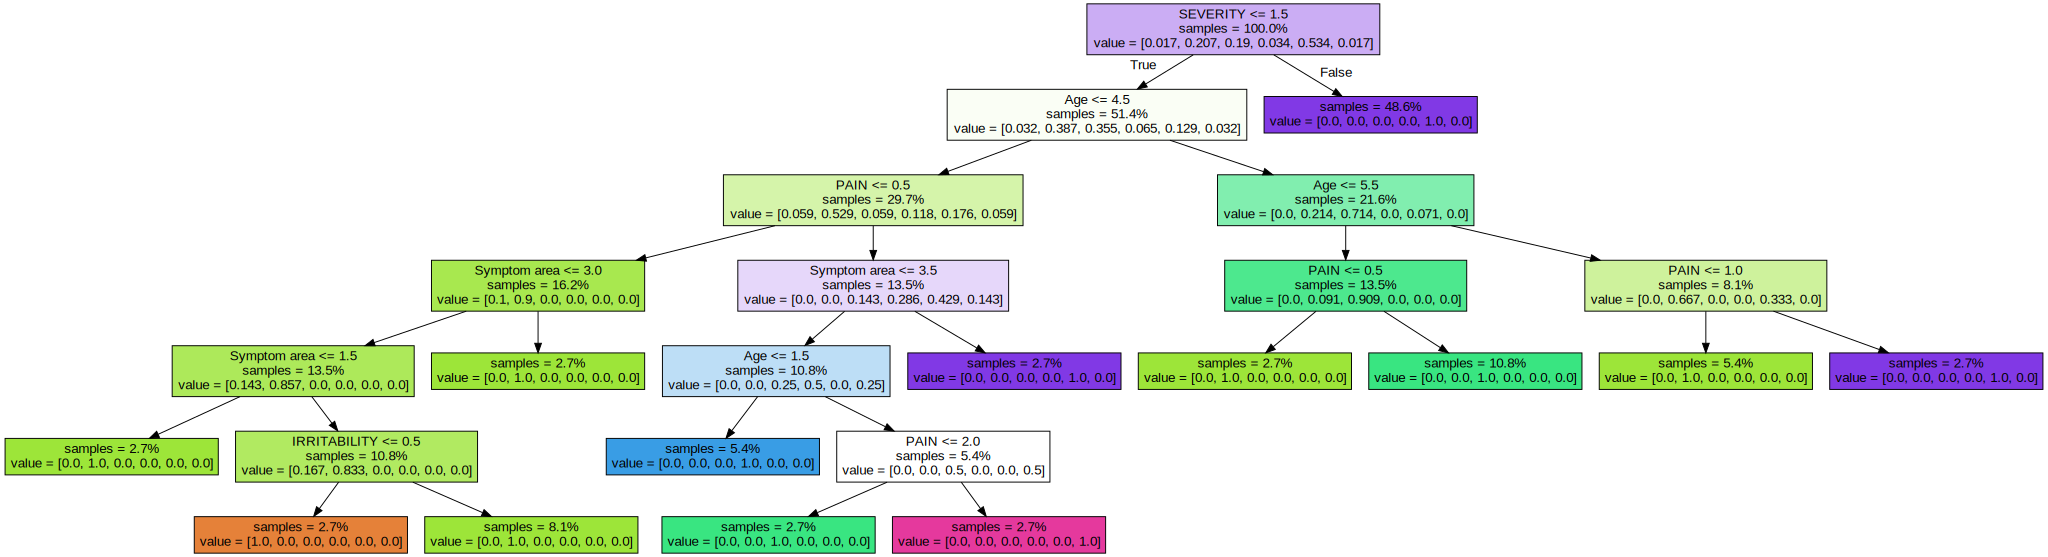

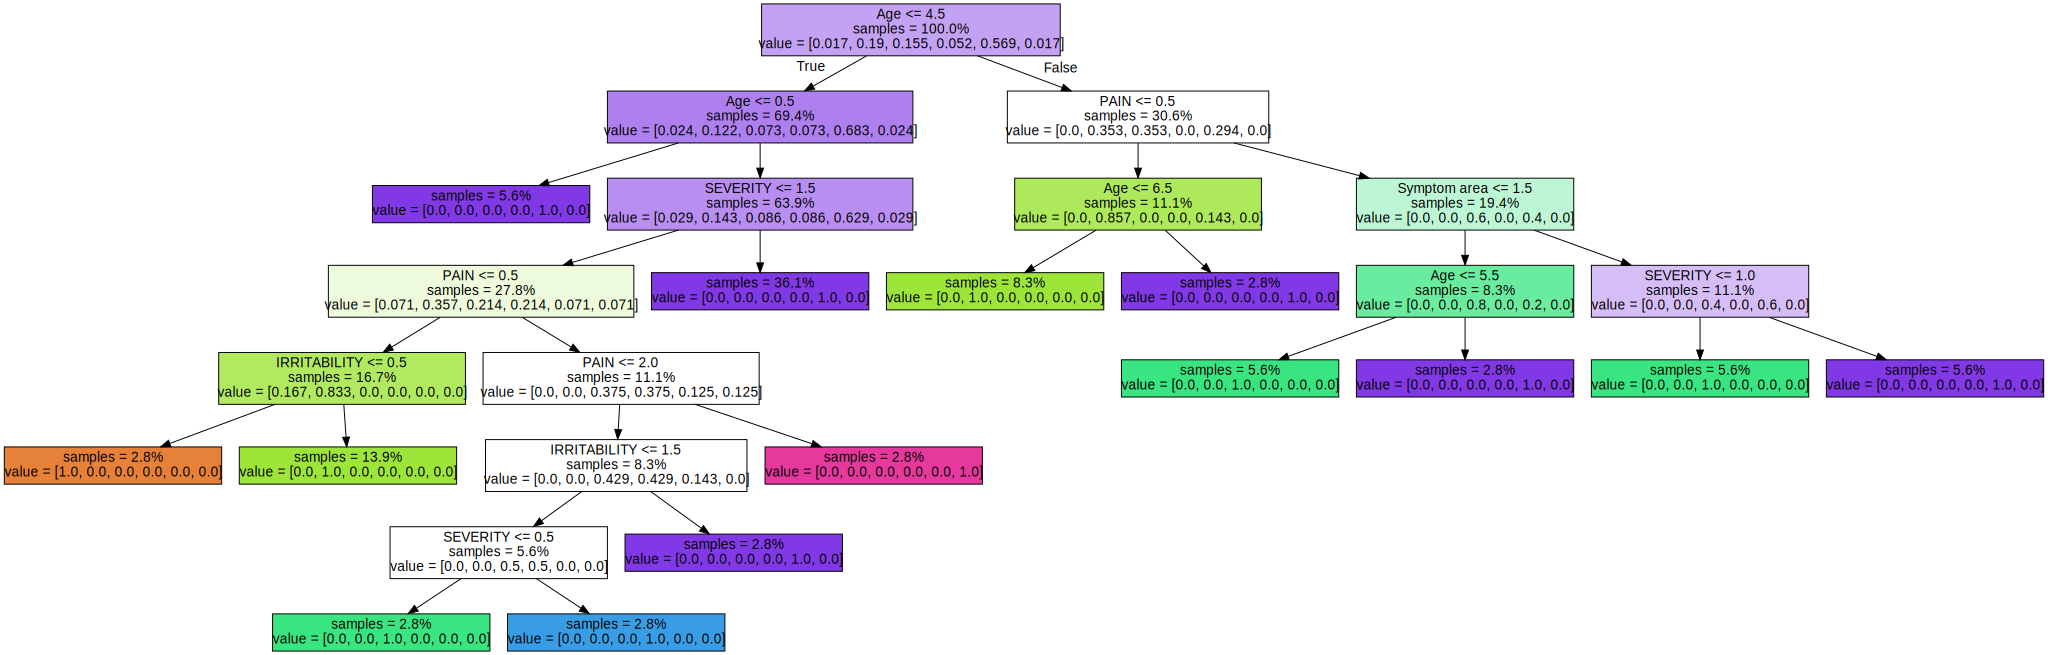

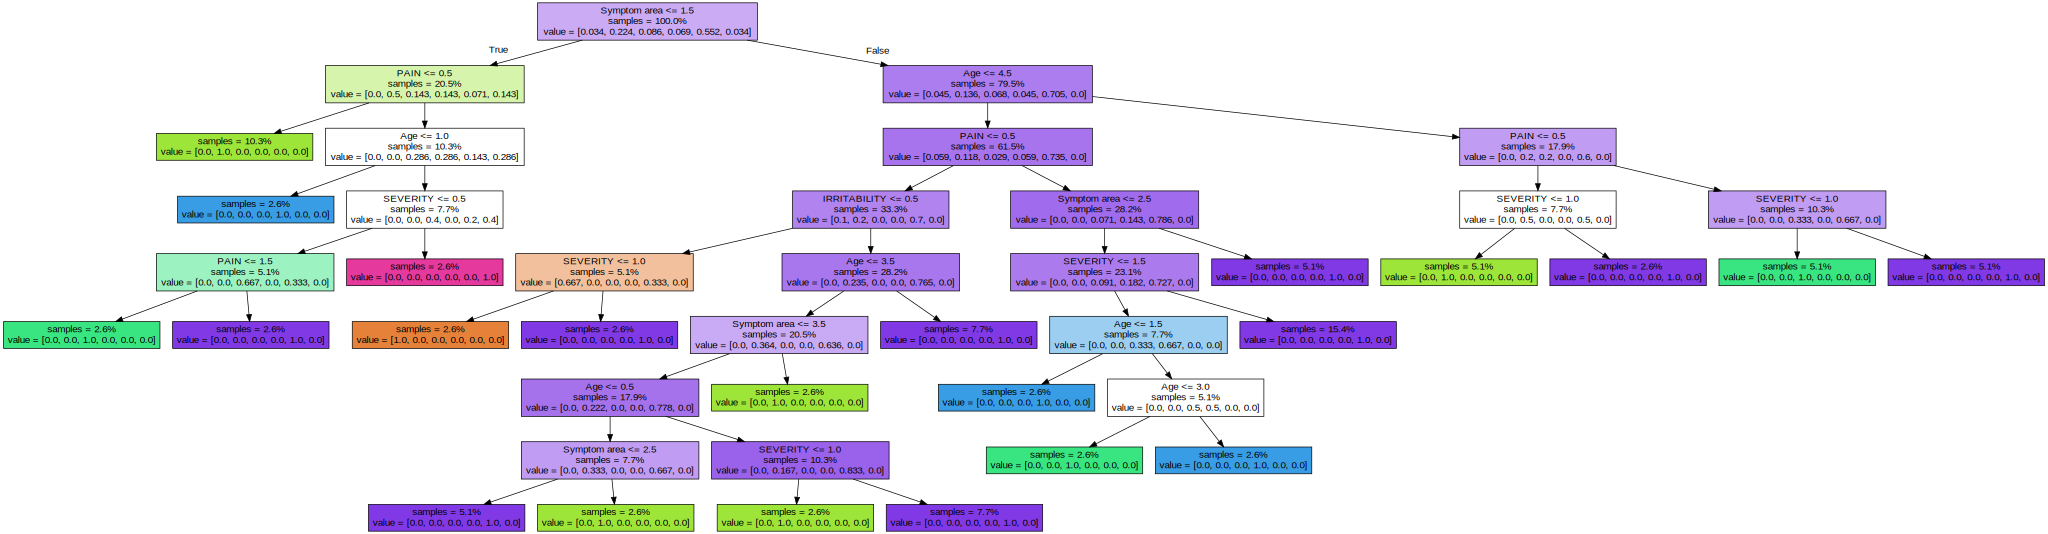

In [ ]:
# Print 3 decision trees in the random forest
for i in range(3):
  tree = rf.estimators_[i]
  dot_data = export_graphviz(tree,
                               feature_names=['Age', 'Symptom area', 'PAIN', 'IRRITABILITY', 'SEVERITY'],  
                               filled=True,  
                               impurity=False, 
                               proportion=True)
  graph = graphviz.Source(dot_data)
  display(graph)

### Random Forest Classifier 2

Random forest classifier with hyperparameter tuning for five features of the dataset.  

- Age
- Symptom Area
- PAIN
- IRRITABILITY
- SEVERITY

We test the classifier for a predefined splitting percentage value.

In [ ]:
# Classification data based on the original dataset
classification_data = sport_data_classification[['Age', 'Symptom area', 'PAIN', 'IRRITABILITY', 'SEVERITY', 'Page']]

In [ ]:
# Define age group boundaries
bins = []
#bins = pd.IntervalIndex.from_tuples([(age_group[0], age_group[1]) for age_group in age_groups])

for age_group in age_groups:
  bins.append(age_group[0])

bins.append(age_groups[-1][1])

In [ ]:
classification_data['Age'] = pd.cut(classification_data['Age'], bins, include_lowest=True,labels=list(range(0,8)))

<ipython-input-29-ce2644d7bde4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_data['Age'] = pd.cut(classification_data['Age'], bins, include_lowest=True,labels=list(range(0,8)))


In [ ]:
# Split the data into training and test sets
train, test = train_test_split(classification_data, test_size=0.3, random_state=1, stratify=classification_data.Page)

In [ ]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(train[['Age', 'Symptom area', 'PAIN', 'IRRITABILITY', 'SEVERITY']], train['Page'])

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f6a0c39e140>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f6a0a19f1c0>})

In [ ]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 11, 'n_estimators': 108}


In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=108, max_depth=11)
rf_classifier.fit(train[['Age', 'Symptom area', 'PAIN', 'IRRITABILITY', 'SEVERITY']], train['Page'])
y_pred = rf_classifier.predict(test[['Age', 'Symptom area', 'PAIN', 'IRRITABILITY', 'SEVERITY']])

In [ ]:
print(classification_report(test['Page'], y_pred, zero_division=0))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.83      1.00      0.91         5
           3       0.80      1.00      0.89         4
           4       1.00      1.00      1.00         1
           5       0.93      0.93      0.93        14
           6       0.00      0.00      0.00         1

    accuracy                           0.88        26
   macro avg       0.59      0.65      0.62        26
weighted avg       0.82      0.88      0.85        26



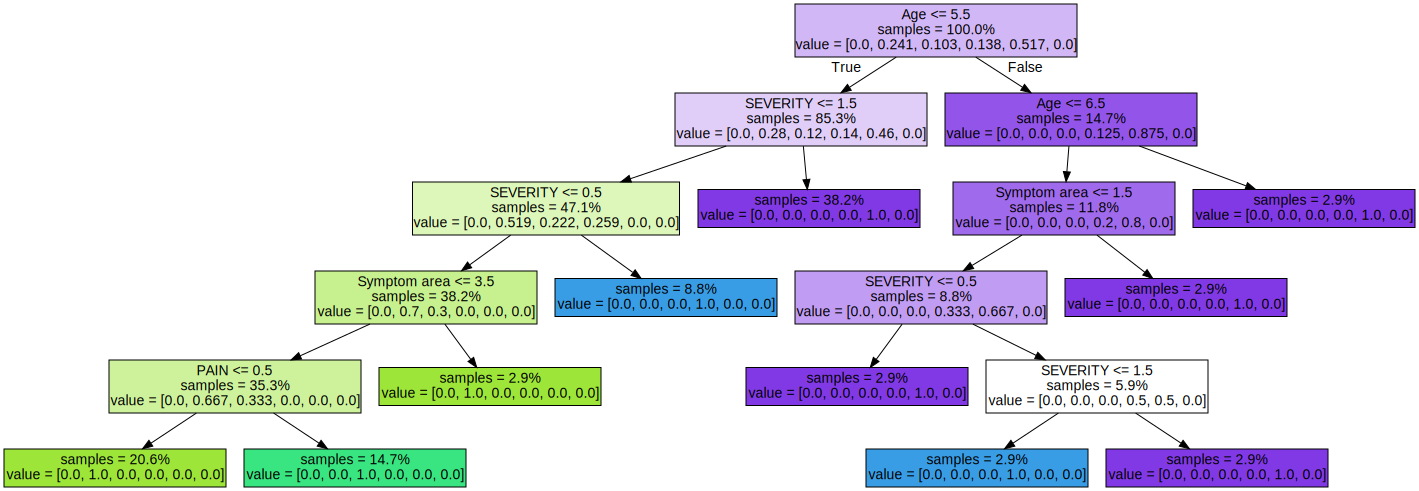

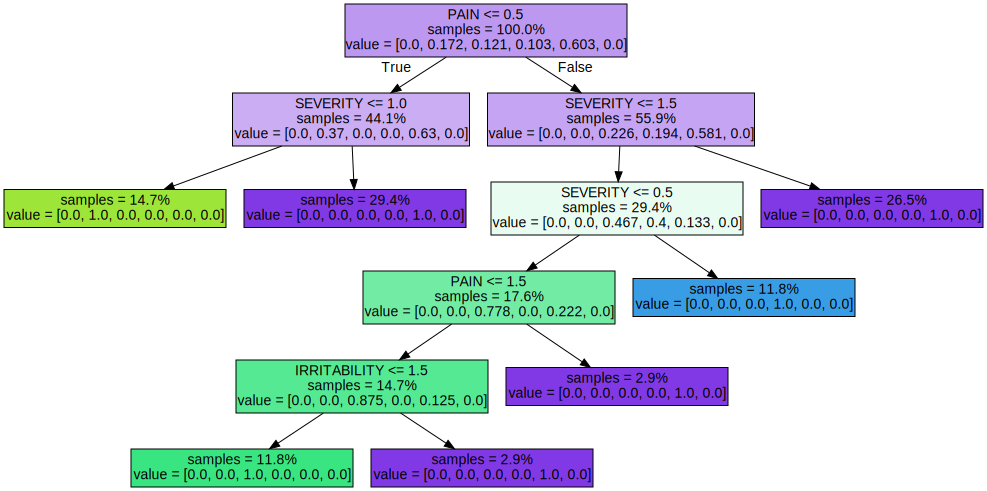

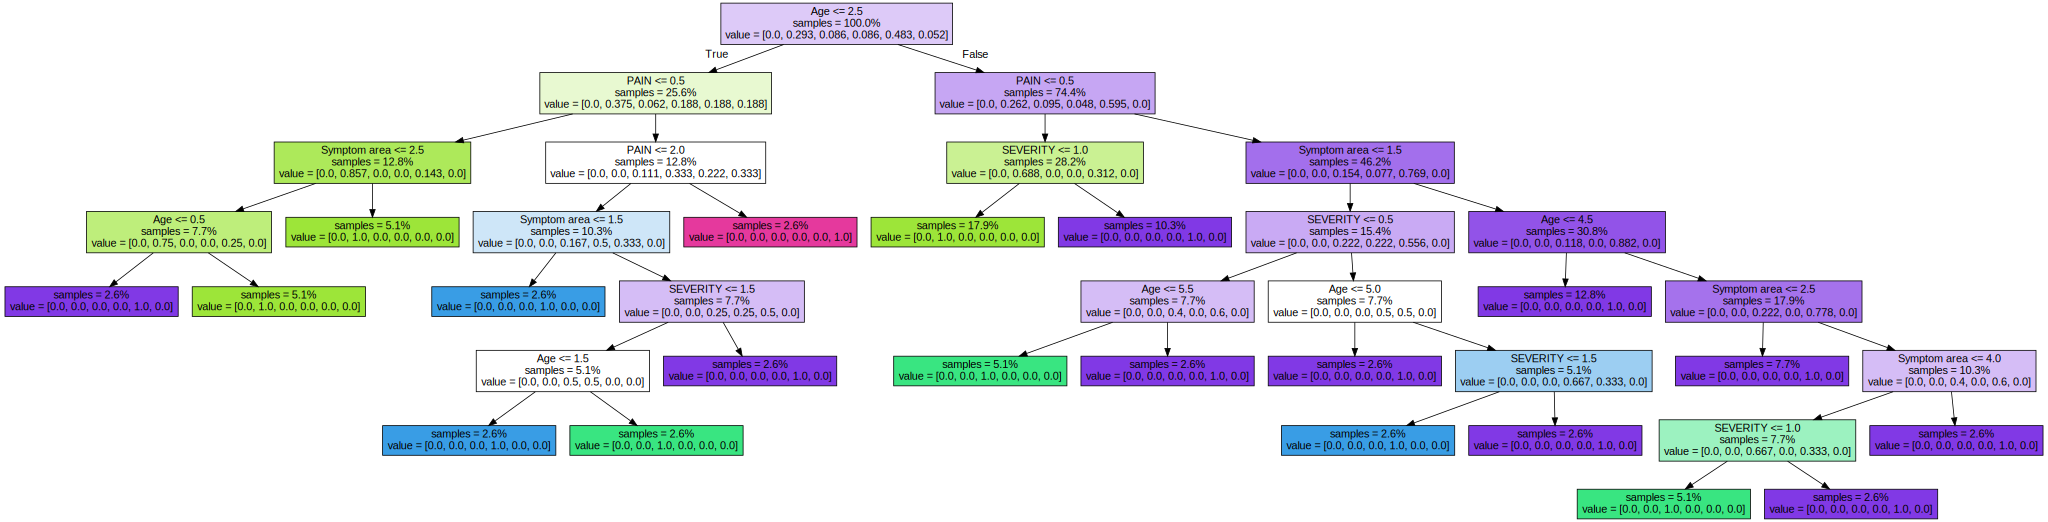

In [ ]:
# Print 3 decision trees in the random forest
for i in range(3):
  tree = rf_classifier.estimators_[i]
  dot_data = export_graphviz(tree,
                               feature_names=train[['Age', 'Symptom area', 'PAIN', 'IRRITABILITY', 'SEVERITY']].columns,  
                               filled=True,  
                               impurity=False, 
                               proportion=True)
  graph = graphviz.Source(dot_data)
  display(graph)